In [210]:
import json
import math

from atproto_client.models.app.bsky.actor.defs import ProfileView, ProfileViewDetailed
from atproto_client.models.app.bsky.feed.defs import ThreadViewPost
from atproto_client.models.app.bsky.feed.post import GetRecordResponse
from atproto_client.models.app.bsky.feed.get_likes import Like
from atproto_client.models.app.bsky.feed.get_post_thread import Response as PostThreadResponse

import pandas as pd
import matplotlib.pyplot as plt

from lib.helper import client
from services.classify.models.perspective_api import perform_batch_inference
from services.sync.search.helper import send_request_with_pagination

In [202]:
pd.set_option("max_colwidth", None)

In [16]:
civic_posts = pd.read_csv('sample_bluesky_civic_posts.csv')
noncivic_posts = pd.read_csv('sample_bluesky_noncivic_posts.csv')

Let's grab the most up-to-date engagement data for each post. We have the link for each post so we can easily get the post ID. Let's grab the post record object given the link for the post.

### Step 1: Grab post information given the link to a post

In [3]:
def get_author_handle_and_post_id_from_link(link: str) -> dict[str, str]:
    """Given a link, get the author and post ID.
    
    Example:
    >get_author_and_post_id_from_link("https://bsky.app/profile/scottsantens.com/post/3knqkh2es7k2i")
    {'author': 'scottsantens.com', 'post_id': '3knqkh2es7k2i}
    """
    # Split the link by the forward slash
    split_link = link.split("/")
    # Get the author and post ID
    author = split_link[4]
    post_id = split_link[6]
    return {"author": author, "post_id": post_id}

In [4]:
def get_author_did_from_handle(author_handle: str) -> str:
    """Given an author handle, get the DID.
    
    Example:
    >get_author_did_from_handle("scottsantens.com")
    "did:example:123"
    """
    # Get the profile
    profile = client.get_profile(author_handle)
    # Get the DID
    return profile["did"]


In [5]:
def get_post_record_from_post_link(link: str) -> GetRecordResponse:
    """Given a post link, get the post record.
    
    Example:
    >post = get_post_record_from_post_link("https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24")
    GetRecordResponse(
        uri='at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knssi4ouko24',
        value=Record(created_at='2024-03-16T12:17:36.784Z', text='A running theme in Woods\' telling is how even those who opposed Hitler blamed his rise on the "depravity" and excess of Weimar Berlin "as if the mere presence of ersatz women in the club was enough to foment and justify a right-wing putsch"--a phrase I find myself repeating often', embed=Main(record=Main(cid='bafyreiesskdi2vfkrvj2kaajglsklqd7b3wywn2goyxhr7ctl3kvaikbsa', uri='at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knss3jmoeu2f', py_type='com.atproto.repo.strongRef'), py_type='app.bsky.embed.record'), entities=None, facets=None, labels=None, langs=['en'], reply=None, tags=None, py_type='app.bsky.feed.post'),
        cid='bafyreidujr2qzblrtxyh6e5shqtjdool2c7vim5jsqybdhi4pkpuphuj5q'
    )
    """
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    author_did: str = get_author_did_from_handle(author_and_post_id["author"])
    post_rkey = author_and_post_id["post_id"]
    profile_identify = author_did
    print(f"Getting post record for {post_rkey} by {profile_identify}")
    response = client.get_post(
        post_rkey=post_rkey, profile_identify=profile_identify
    )
    return response

### Step 1: Given a post URI, grab engagement data (reposts, likes, replies)

In [6]:
def get_repost_profiles(post_uri: str) -> list[ProfileView]:
    """Get the profiles of all the users who reposted a post."""
    reposts: list[ProfileView] = send_request_with_pagination(
        func=client.get_reposted_by,
        kwargs={"uri": post_uri},
        response_key="reposted_by",
        limit=None,
        silence_logs=True
    )
    return reposts

In [7]:
def get_liked_by_profiles(post_uri: str) -> list[Like]:
    """Get the profiles of all the users who liked a post."""
    likes: list[Like] = send_request_with_pagination(
        func=client.get_likes,
        kwargs={"uri": post_uri},
        response_key="likes",
        limit=None,
        silence_logs=True
    )
    return likes

In [8]:
def get_post_thread_replies(post_uri: str) -> list[ThreadViewPost]:
    """Get the thread of replies to a post."""
    response: PostThreadResponse = client.get_post_thread(post_uri)
    thread: ThreadViewPost = response.thread
    replies: list[ThreadViewPost] = thread.replies
    return replies

In [9]:
def calculate_post_engagement(post_response: GetRecordResponse) -> dict:
    """Calculates the number of likes, retweets, and comments for a post."""
    uri = post_response["uri"]

    # grab # of likes
    likes: list[Like] = get_liked_by_profiles(uri)
    num_likes: int = len(likes)

    # grab # of retweets/reposts
    reposts: list[ProfileView] = get_repost_profiles(uri)
    num_reposts = len(reposts)

    # grab # of replies
    replies: list[ThreadViewPost] = get_post_thread_replies(uri)
    num_replies = len(replies)

    return {
        "uri": uri,
        "num_likes": num_likes,
        "num_reposts": num_reposts,
        "num_replies": num_replies
    }


### Step 3: Let's calculate the post engagement given a post link

In [10]:
def calculate_post_engagement_from_link(link: str) -> dict:
    """Calculates the number of likes, retweets, and comments for a post given a link."""
    post_response: GetRecordResponse = get_post_record_from_post_link(link)
    post_engagement = calculate_post_engagement(post_response)
    return {
        "link": link,
        "created_at": post_response.value.created_at,
        **post_engagement
    }

### Step 4: Let's apply this function to each of the posts that we have, in order to get up-to-date engagement data for each post


In [11]:
map_link_to_engagement_data = {} # cache so we don't make duplicate requests

In [12]:
def write_engagement_data_to_json(engagement_data: dict) -> None:
    post_id = engagement_data["uri"].split("/")[-1]
    json_filename = f"engagement_data/engagement_data_{post_id}.json"
    with open(json_filename, "w") as f:
        json.dump(engagement_data, f)

In [13]:
def generate_post_engagement_data_from_link(link: str) -> dict:
    """Generates the post engagement data from a link."""
    if link in map_link_to_engagement_data:
        print(f"Engagement data already exists for {link}. Returning cached data.")
        return map_link_to_engagement_data[link]
    else:
        post_engagement_data = calculate_post_engagement_from_link(link)
        map_link_to_engagement_data[link] = post_engagement_data
        write_engagement_data_to_json(post_engagement_data)
        return post_engagement_data

In [14]:
civic_links = civic_posts["Link"].tolist()
noncivic_links = noncivic_posts["Link"].tolist()

In [ ]:
# takes 18 minutes to run for ~180 posts. Grossly inefficient, please don't run.
# to future Mark: please use caching, thanks. Also see if you can bundle requests.
"""
for link in civic_posts["Link"].tolist():
    try:
        generate_post_engagement_data_from_link(link)
    except Exception as e:
        print(f"Unable to generate post engagement data for {link}: {e}")
        continue
"""

In [41]:
civic_posts_engagement_data = [item[1] for item in map_link_to_engagement_data.items()]

Note: using a for-loop and making all these requests is grossly inefficient (~15 minutes and lots of requests), so I'll just manually impute for the noncivic posts.

In [ ]:
"""
for link in noncivic_posts["Link"].tolist():
    try:
        generate_post_engagement_data_from_link(link)
    except Exception as e:
        print(f"Unable to generate post engagement data for {link}: {e}")
        continue
"""

In [98]:
civic_posts_engagement_data[0]

{'link': 'https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24',
 'created_at': '2024-03-16T12:17:36.784Z',
 'uri': 'at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knssi4ouko24',
 'num_likes': 384,
 'num_reposts': 83,
 'num_replies': 9,
 'civic': True}

I need to add in the "Text" and "Feed" columns, stupidly I didn't do this.

In [115]:
civic_posts_subset = civic_posts[["Link", "Text", "Feed"]]

# lowercase and change the column names
civic_posts_subset.columns = ["link", "text", "source_feed"]

In [116]:
civic_posts_subset.head()

,link,text,source_feed
0,https://bsky.app/profile/gbbranstetter.bsky.so...,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
1,https://bsky.app/profile/juliusgoat.bsky.socia...,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
2,https://bsky.app/profile/jbouie.bsky.social/po...,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
3,https://bsky.app/profile/gbbranstetter.bsky.so...,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
4,https://bsky.app/profile/jameeljaffer.bsky.soc...,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...


In [143]:
foo = pd.DataFrame(civic_posts_engagement_data)

In [144]:
foo.shape

(361, 7)

In [117]:
civic_posts_df = pd.merge(
    pd.DataFrame(civic_posts_engagement_data),
    civic_posts_subset,
    left_on="link",
    right_on="link",
    how="left"
)

In [141]:
civic_posts_engagement_data_enriched = civic_posts_df.to_dict(orient="records")

In [142]:
civic_posts_df.shape

(367, 9)

In [23]:
noncivic_posts_dicts: list[dict] = noncivic_posts.to_dict(orient="records")

In [24]:
noncivic_posts_dicts[0]

{'Link': 'https://bsky.app/profile/joshuaerlich.bsky.social/post/3knsul6pqtk2x',
 'Text': 'it really is incredible how much of the last 20 years of tech ‘innovation’ is useless bullshit that kills the environment and fucks labor',
 'Retweets': 159,
 'Likes': 775,
 'Comments': 25,
 'Feed': 'https://bsky.app/profile/did:plc:z72i7hdynmk6r22z27h6tvur/feed/hot-classic',
 'Timestamp': '3/16/2024'}

We need to get the URI and created_at for each of the noncivic posts. Otherwise we (manually) have all the engagement information

In [95]:
noncivic_posts_engagement_data = []
total_noncivic_posts = len(noncivic_posts_dicts)

In [ ]:
# ~ 2 minutes / 200 posts 
for idx, noncivic_post in enumerate(noncivic_posts_dicts):
    if idx % 20 == 0:
        print(f"Processing post index {idx} of {total_noncivic_posts}")
    link = noncivic_post["Link"]
    if link in map_link_to_engagement_data:
        print(f"Engagement data already exists for {link}. Returning cached data.")
        #noncivic_posts_engagement_data.append(map_link_to_engagement_data[link])
        response_data = map_link_to_engagement_data[link]
        # continue
    else:
        try:
            post_response: GetRecordResponse = get_post_record_from_post_link(link)
            uri = post_response["uri"]
            created_at = post_response.value.created_at
            response_data = {"uri": uri, "created_at": created_at, "link": link}
        except Exception as e:
            print(f"Unable to get post record for {link}: {e}")
            continue
    post_engagement_data = {
        "num_likes": noncivic_post["Likes"],
        "num_reposts": noncivic_post["Retweets"],
        "num_replies": noncivic_post["Comments"],
        "text": noncivic_post["Text"],
        "source_feed": noncivic_post["Feed"]
    }
    post_engagement_data = {**response_data, **post_engagement_data}
    map_link_to_engagement_data[link] = post_engagement_data
    noncivic_posts_engagement_data.append(post_engagement_data)
    #write_engagement_data_to_json(post_engagement_data)

Now that we have the engagement data for both civic and noncivic posts, let's aggregate them.

In [151]:
bluesky_pilot_posts: list[dict] = []

In [152]:
set_noncivic_post_uris = set([item["uri"] for item in noncivic_posts_engagement_data])

In [153]:
# while processing, data got polluted, so I need to extract just the civic posts.
filtered_civic_posts_engagement_data_enriched = [
    civic_post for civic_post in civic_posts_engagement_data_enriched
    if civic_post["uri"] not in set_noncivic_post_uris
]

In [155]:
for post in filtered_civic_posts_engagement_data_enriched:
    post["civic"] = True
    bluesky_pilot_posts.append(post)

for post in noncivic_posts_engagement_data:
    post["civic"] = False
    bluesky_pilot_posts.append(post)

In [157]:
bluesky_pilot_posts_df = pd.DataFrame(bluesky_pilot_posts)

In [124]:
bluesky_pilot_posts_df.head(10)

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed
0,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
1,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
2,https://bsky.app/profile/juliusgoat.bsky.socia...,2024-03-16T12:32:35.934Z,at://did:plc:tzy4hibtkautrntsz5f3ns37/app.bsky...,346,89,8,True,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
3,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-16T12:32:25.792Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,926,280,27,True,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
4,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:32:05.540Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,99,20,1,True,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
5,https://bsky.app/profile/jameeljaffer.bsky.soc...,2024-03-16T12:28:54.641Z,at://did:plc:eqtfqntwixcnk2fn6im5ntwr/app.bsky...,252,32,11,True,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
6,https://bsky.app/profile/ohnoshetwitnt.bsky.so...,2024-03-16T13:31:16.518Z,at://did:plc:qbvmzulle4ytussf2qpzoqqd/app.bsky...,275,26,8,True,The fact that Bill Maher has Republicans defen...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
7,https://bsky.app/profile/ohnoshetwitnt.bsky.so...,2024-03-16T13:31:16.518Z,at://did:plc:qbvmzulle4ytussf2qpzoqqd/app.bsky...,275,26,8,True,The fact that Bill Maher has Republicans defen...,https://bsky.app/profile/did:plc:tenurhgjptubk...
8,https://bsky.app/profile/esqueer.bsky.social/p...,2024-03-15T21:00:06.688Z,at://did:plc:sefgphqp2xqwh2hawaixykwz/app.bsky...,3087,1409,155,True,Twitter is nuking every single post that menti...,https://bsky.app/profile/did:plc:tenurhgjptubk...
9,https://bsky.app/profile/chriswarcraft.bsky.so...,2024-03-15T22:20:33.356Z,at://did:plc:oofa3qqoiszsmajbigfqskqv/app.bsky...,2642,590,39,True,I don’t want Supreme Court justices that are f...,https://bsky.app/profile/did:plc:tenurhgjptubk...


In [125]:
bluesky_pilot_posts_df.to_csv("bluesky_pilot_posts.csv", index=False)

An oversight on my end was not calculating superposters. We can do this by looking at the number of posts that a person has written, which should be easily available. For a first pass, we can check if they've written more than 25 posts in the past week.

In [47]:
def get_author_profile_from_link(link: str) -> ProfileViewDetailed:
    """Given a link, get the author profile.
    
    Example:
    >get_author_profile_from_link("https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24)
    ProfileViewDetailed(
        did='did:plc:mlmouohgzbjofidukcp4pxf2',
        handle='gbbranstetter.bsky.social',
        avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:mlmouohgzbjofidukcp4pxf2/bafkreicdpwjn4jyxlcbkxmm7baha6vfohzujcjfre6vvx35vruhud64a7e@jpeg',
        banner='https://cdn.bsky.app/img/banner/plain/did:plc:mlmouohgzbjofidukcp4pxf2/bafkreidnd5k7yltrbprbygfgpzoxngihqp4aziouuwsvsecindofzipjhe@jpeg',
        description='comms strategy @aclu // autonomy.substack.com // opinions my own ',
        display_name='Gillian Branstetter',
        followers_count=14545,
        follows_count=502,
        indexed_at='2024-03-20T14:58:09.443Z',
        labels=[Label(cts='1970-01-01T00:00:00.000Z', src='did:plc:mlmouohgzbjofidukcp4pxf2', uri='at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.actor.profile/self', val='!no-unauthenticated', cid='bafyreigay5agy6hjvqnbi2xcn4bwinxaw4g5g3vjcxjsom5me7njrigv2a', neg=None, py_type='com.atproto.label.defs#label')],
        posts_count=4429,
        viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'),
        py_type='app.bsky.actor.defs#profileViewDetailed',
        associated={'lists': 0, 'feedgens': 0, 'labeler': False}
    )
    """
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    author_did: str = get_author_did_from_handle(author_and_post_id["author"])
    return client.get_profile(author_did)

In [48]:
links = bluesky_pilot_posts_df["link"].tolist()

In [56]:
author_did_to_profile: dict[str, dict] = {}

In [ ]:
# ~6 minutes for 300 posts
for link in links:
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    author_did: str = get_author_did_from_handle(author_and_post_id["author"])
    if author_did in author_did_to_profile:
        continue
    try:
        author_profile = get_author_profile_from_link(link)
        author_did_to_profile[author_did] = author_profile.__dict__
    except Exception as e:
        print(f"Unable to get author profile for {author_did}: {e}")
        continue

In [58]:
len(author_did_to_profile.keys())

238

In [78]:
pilot_post_authors_df = pd.DataFrame(author_did_to_profile.values())

Now let's classify certain authors as superposters or not.

First, let's do some EDA on the authors and see how many posts they each have. Maybe we can set a threshold of picking author in the top X% of posts?

In [63]:
pilot_post_authors_df["posts_count"]

0      4429
1      1753
2      4671
3       193
4       610
       ... 
233    3078
234    2857
235    1287
236    1494
237    2874
Name: posts_count, Length: 238, dtype: int64

<Axes: ylabel='Frequency'>

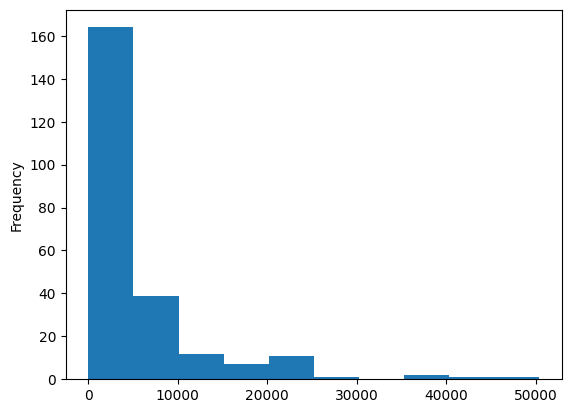

In [67]:
# plot histogram of posts_count
pilot_post_authors_df["posts_count"].plot.hist()


OK, seems like very long-tailed behavior. Let me get some more fine-grained details.

In [70]:
# calculate top 1% of post_count
top_1_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.99)

# calculate top 5% of post_count
top_5_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.95)

# calculate top 10% of post_count
top_10_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.90)

# calculate top 25% of post_count
top_25_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.75)

# calculate top 50% of post_count
top_50_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.50)

In [75]:
print(f"Top 1%: {top_1_percent_post_count}")
print(f"Top 5%: {top_5_percent_post_count}")
print(f"Top 10%: {top_10_percent_post_count}")
print(f"Top 25%: {top_25_percent_post_count}")
print(f"Top 50%: {top_50_percent_post_count}")

Top 1%: 35724.15
Top 5%: 21824.349999999984
Top 10%: 14157.40000000001
Top 25%: 6296.0
Top 50%: 2851.5


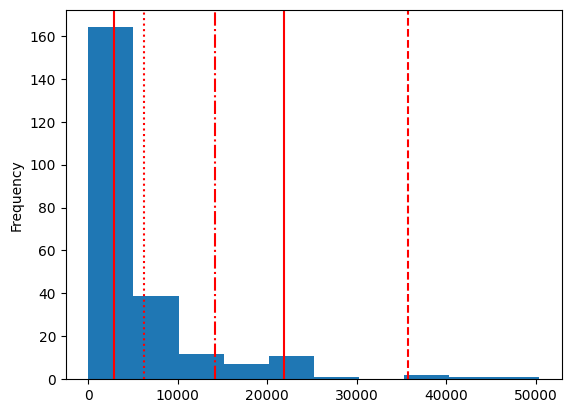

In [74]:
# add the quantiles as vertical red lines to the histogram. Add a legend to the plot.
# add labels to each red line.
pilot_post_authors_df["posts_count"].plot.hist()
plt.axvline(top_1_percent_post_count, color='r', linestyle='--', label="Top 1%")
plt.axvline(top_5_percent_post_count, color='r', linestyle='-', label="Top 5%")
plt.axvline(top_10_percent_post_count, color='r', linestyle='-.', label="Top 10%")
plt.axvline(top_25_percent_post_count, color='r', linestyle=':', label="Top 25%")
plt.axvline(top_50_percent_post_count, color='r', linestyle='-', label="Top 50%")
plt.show()

Let's just use authors in the top 25% for now. I suspect that in the wider population, these would already be long-tailed users.

In [79]:
# create a new column, "is_frequent_poster", that is 1 if the user's post_count
# is above the top 25% of post_count, and 0 otherwise.
pilot_post_authors_df["is_frequent_poster"] = (
    pilot_post_authors_df["posts_count"] > top_25_percent_post_count
)

In [80]:
pilot_post_authors_df.to_csv("bluesky_pilot_posts_authors.csv", index=False)

Now let's combine the post and the author data in order to enrich each post with information about its author. Specifically, we need to add the "is_frequent_poster" column to the post table.

We'll do this by grabbing the handle from the `link` column in the `bluesky_pilot_posts_df` DataFrame, mapping that to the `handle` column in the `pilot_post_authors_df` DataFrame.

In [83]:
def get_author_handle_from_link(link: str) -> str:
    """Given a link, get the author handle.
    
    Example:
    >get_author_handle_from_link("https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24)
    "gbbranstetter.bsky.social"
    """
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    return author_and_post_id["author"]

In [158]:
bluesky_pilot_posts_df["author_handle"] = bluesky_pilot_posts_df["link"].apply(get_author_handle_from_link)

In [159]:
enriched_bluesky_pilot_posts_df = bluesky_pilot_posts_df.merge(
    pilot_post_authors_df[["handle", "is_frequent_poster"]],
    left_on="author_handle",
    right_on="handle",
    how="left"
)

In [160]:
enriched_bluesky_pilot_posts_df["is_frequent_poster"].value_counts()

is_frequent_poster
False    259
True     113
Name: count, dtype: int64

In [161]:
# drop duplicates based on "link" column
enriched_bluesky_pilot_posts_df = (
    enriched_bluesky_pilot_posts_df.drop_duplicates(subset=["link"])
)

In [164]:
enriched_bluesky_pilot_posts_df.head()

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed,author_handle,handle,is_frequent_poster
0,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,gbbranstetter.bsky.social,False
2,https://bsky.app/profile/juliusgoat.bsky.socia...,2024-03-16T12:32:35.934Z,at://did:plc:tzy4hibtkautrntsz5f3ns37/app.bsky...,346,89,8,True,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,juliusgoat.bsky.social,juliusgoat.bsky.social,False
3,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-16T12:32:25.792Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,926,280,27,True,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jbouie.bsky.social,jbouie.bsky.social,False
4,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:32:05.540Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,99,20,1,True,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,gbbranstetter.bsky.social,False
5,https://bsky.app/profile/jameeljaffer.bsky.soc...,2024-03-16T12:28:54.641Z,at://did:plc:eqtfqntwixcnk2fn6im5ntwr/app.bsky...,252,32,11,True,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jameeljaffer.bsky.social,jameeljaffer.bsky.social,False


In [163]:
enriched_bluesky_pilot_posts_df["civic"].value_counts()

civic
False    187
True     174
Name: count, dtype: int64

In [165]:
enriched_bluesky_pilot_posts_df.to_csv("bluesky_pilot_posts.csv", index=False)

OK, now we have the engagement data plus if the post author is a frequent poster.

### Step 5: Let's get inference data for each of these posts

Now that we have the posts, let's use the Perspective API to get toxicity and constructiveness data for these posts and add these as features.

In [167]:
post_uri_to_text_map = {}

for idx, row in enriched_bluesky_pilot_posts_df.iterrows():
    uri = row["uri"]
    text = row["text"]
    post_uri_to_text_map[uri] = text

In [168]:
texts = list(post_uri_to_text_map.values())

In [ ]:
# pings Perspective API
classifications: list[dict] = perform_batch_inference(texts)

In [174]:
len(post_uri_to_text_map.keys())

361

In [173]:
len(classifications)

361

In [175]:
classifications[0]

{'text': 'A running theme in Woods\' telling is how even those who opposed Hitler blamed his rise on the "depravity" and excess of Weimar Berlin "as if the mere presence of ersatz women\nin theclubwas enough to foment and justify a right-wing putsch"--a phrase I find myself repeating often',
 'prob_toxic': 0.15103401,
 'label_toxic': 0,
 'prob_affinity': 0.26146647,
 'label_affinity': 0,
 'prob_compassion': 0.17844121,
 'label_compassion': 0,
 'prob_constructive': 0.4490613,
 'label_constructive': 0,
 'prob_curiosity': 0.39127967,
 'label_curiosity': 0,
 'prob_nuance': 0.43793672,
 'label_nuance': 0,
 'prob_personal_story': 0.29584426,
 'label_personal_story': 0,
 'prob_alienation': 0.6844828,
 'label_alienation': 1,
 'prob_fearmongering': 0.15237163,
 'label_fearmongering': 0,
 'prob_generalization': 0.5528038,
 'label_generalization': 1,
 'prob_moral_outrage': 0.44657364,
 'label_moral_outrage': 0,
 'prob_scapegoating': 0.30857164,
 'label_scapegoating': 0}

In [176]:
post_uri_to_text_labels_map = {}

for idx, uri in enumerate(post_uri_to_text_map.keys()):
    post_uri_to_text_labels_map[uri] = classifications[idx]

In [178]:
classifications_dicts_list: list[dict] = [
    {**{"did": key}, **item}
    for (key, item) in post_uri_to_text_labels_map.items()
]

In [179]:
classifications_dicts_list[0]

{'did': 'at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knssi4ouko24',
 'text': 'A running theme in Woods\' telling is how even those who opposed Hitler blamed his rise on the "depravity" and excess of Weimar Berlin "as if the mere presence of ersatz women\nin theclubwas enough to foment and justify a right-wing putsch"--a phrase I find myself repeating often',
 'prob_toxic': 0.15103401,
 'label_toxic': 0,
 'prob_affinity': 0.26146647,
 'label_affinity': 0,
 'prob_compassion': 0.17844121,
 'label_compassion': 0,
 'prob_constructive': 0.4490613,
 'label_constructive': 0,
 'prob_curiosity': 0.39127967,
 'label_curiosity': 0,
 'prob_nuance': 0.43793672,
 'label_nuance': 0,
 'prob_personal_story': 0.29584426,
 'label_personal_story': 0,
 'prob_alienation': 0.6844828,
 'label_alienation': 1,
 'prob_fearmongering': 0.15237163,
 'label_fearmongering': 0,
 'prob_generalization': 0.5528038,
 'label_generalization': 1,
 'prob_moral_outrage': 0.44657364,
 'label_moral_outrage': 0,
 'pr

In [182]:
classifications_df = pd.DataFrame(classifications_dicts_list)

In [184]:
# join to the posts df on the did column
enriched_posts_df = enriched_bluesky_pilot_posts_df.merge(
    classifications_df,
    left_on="uri",
    right_on="did",
    how="left"
)

In [185]:
enriched_posts_df.head()

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text_x,source_feed,author_handle,...,prob_alienation,label_alienation,prob_fearmongering,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating
0,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,...,0.684483,1,0.152372,0,0.552804,1,0.446574,0,0.308572,0
1,https://bsky.app/profile/juliusgoat.bsky.socia...,2024-03-16T12:32:35.934Z,at://did:plc:tzy4hibtkautrntsz5f3ns37/app.bsky...,346,89,8,True,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,juliusgoat.bsky.social,...,0.821005,1,0.154572,0,0.848215,1,0.698824,1,0.844623,1
2,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-16T12:32:25.792Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,926,280,27,True,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jbouie.bsky.social,...,0.126333,0,0.102600,0,0.083667,0,0.106318,0,0.130182,0
3,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:32:05.540Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,99,20,1,True,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,...,0.604766,1,0.218729,0,0.722730,1,0.267576,0,0.449304,0
4,https://bsky.app/profile/jameeljaffer.bsky.soc...,2024-03-16T12:28:54.641Z,at://did:plc:eqtfqntwixcnk2fn6im5ntwr/app.bsky...,252,32,11,True,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jameeljaffer.bsky.social,...,0.101003,0,0.137085,0,0.078890,0,0.112315,0,0.112025,0


In [186]:
enriched_posts_df.columns

Index(['link', 'created_at', 'uri', 'num_likes', 'num_reposts', 'num_replies',
       'civic', 'text_x', 'source_feed', 'author_handle', 'handle',
       'is_frequent_poster', 'did', 'text_y', 'prob_toxic', 'label_toxic',
       'prob_affinity', 'label_affinity', 'prob_compassion',
       'label_compassion', 'prob_constructive', 'label_constructive',
       'prob_curiosity', 'label_curiosity', 'prob_nuance', 'label_nuance',
       'prob_personal_story', 'label_personal_story', 'prob_alienation',
       'label_alienation', 'prob_fearmongering', 'label_fearmongering',
       'prob_generalization', 'label_generalization', 'prob_moral_outrage',
       'label_moral_outrage', 'prob_scapegoating', 'label_scapegoating'],
      dtype='object')

In [193]:
# drop text_y, rename text_x to text
enriched_posts_df = enriched_posts_df.drop(columns=["text_y"])
enriched_posts_df = enriched_posts_df.rename(columns={"text_x": "text"})

In [194]:
# after adding features, save the .csv file again.
enriched_posts_df.to_csv("bluesky_pilot_posts_with_all_features.csv", index=False)

Now that we have the full dataframe with all features, let's generate our feeds.

### Step 6: Generate feeds

#### 6.1 Reverse-Chronological Feeds
For the reverse-chronological, we will just sort based on timestamp.

For these ones, we would likely get better results if we didn't grab all high-like posts. We could just grab random posts that were posted on the same day as well.

I can pull these from the firehose? Or look for and sample posts that were posted on the same days as the other one.

#### 6.2 Engagement feed

For the engagement feed, we can just sort on the sum of number of likes, reposts, and comments.

In [195]:
enriched_posts_df["total_engagement"] = (
    enriched_posts_df["num_likes"]
    + enriched_posts_df["num_reposts"]
    + enriched_posts_df["num_replies"]
)

In [204]:
engagement_feed_df = enriched_posts_df.copy()

In [206]:
# sort by total_engagement, then return the link, text, num_likes, num_reposts, num_replies, and total_engagement
engagement_feed_df = (
    engagement_feed_df.sort_values(by="total_engagement", ascending=False)
    .reset_index(drop=True)
)

In [231]:
engagement_feed_df.head(3)

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed,author_handle,...,label_alienation,prob_fearmongering,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating,total_engagement
0,https://bsky.app/profile/stuflemingnz.bsky.social/post/3knhplc7vta2r,2024-03-12T02:26:24.296Z,at://did:plc:dg5vxv3natjdyzjbo2hjv5g3/app.bsky.feed.post/3knhplc7vta2r,7357,2521,95,False,The King of England lies dying and one of his sons has been exiled. A princess has vanished. Plague stalks the land and the Treasury has been plundered. NOW is the time for strange women lying in ponds to distribute swords to form the basis of government.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,stuflemingnz.bsky.social,...,1,0.536391,1,0.539647,1,0.463428,0,0.433007,0,9973
1,https://bsky.app/profile/fallonturing.bsky.social/post/3knonywlopd24,2024-03-14T20:46:51.788Z,at://did:plc:5zfcmbupaqsvkiweknzwbt3x/app.bsky.feed.post/3knonywlopd24,4956,1439,39,False,This is the single funniest thing that an algorithm has ever done.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,fallonturing.bsky.social,...,0,0.190371,0,0.267574,0,0.248058,0,0.198434,0,6434
2,https://bsky.app/profile/jwgoerlich.bsky.social/post/3knogawk33c2h,2024-03-14T18:28:12.025Z,at://did:plc:njxcscm7gcrfrimdx3d7vupb/app.bsky.feed.post/3knogawk33c2h,4176,1269,28,False,Shel Silverstein doesn’t get nearly enough credit for predicting ChatGPT.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,jwgoerlich.bsky.social,...,0,0.079411,0,0.327739,0,0.146616,0,0.123458,0,5473


In [208]:
engagement_feed_df.to_csv("engagement_feed.csv", index=False)

#### 6.3 Representative diversification (RD) feed

For the representative diversification feed, we want to update our score based on the following:
1. Penalize posts that are toxic and civic
2. Penalize posts that are by frequent posters and are civic
3. Uprank posts that are constructive and civic.

We will take the base "total_engagement" score and modify it by these parameters.

(Note: in the actual algorithm, we are measuring the probability of engagement that a user has for a given post, but that's not what we're doing here. The post here with the most engagement isn't necessary the post that we'd say, for a given user, has the highest odds of engagement. At first blush, we're just making a hand-wavey claim. But we can assume that all of these posts are likely generally engaging?)

Let's take a log transform of the total engagement and work with that for now.

In [214]:
rd_df = enriched_posts_df.copy()

In [215]:
rd_df["log_total_engagement"] = rd_df["total_engagement"].apply(lambda x: 0 if x == 0 else math.log(x))

<Axes: >

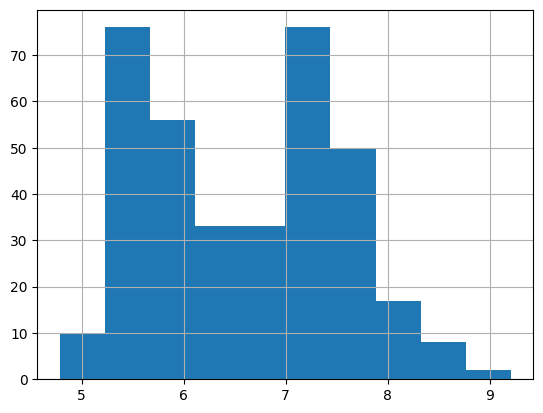

In [220]:
rd_df["log_total_engagement"].hist()

In [219]:
min_log = rd_df["log_total_engagement"].min()
max_log = rd_df["log_total_engagement"].max()
print(f"Min log: {min_log}")
print(f"Max log: {max_log}")

Min log: 4.787491742782046
Max log: 9.207636720401869


Now let's calculate the scores for each post, using the criteria stated above

For the representative diversification feed, we want to update our score based on the following:
1. Penalize posts that are toxic and civic
2. Penalize posts that are by frequent posters and are civic
3. Uprank posts that are constructive and civic.

In [221]:
# hyperparameters
TOXIC_PENALTY = 0.5
FREQUENT_POSTER_PENALITY = 0.5
CONSTRUCTIVE_BONUS = 0.5

In [222]:
rd_posts = rd_df.to_dict(orient="records")

In [224]:
def representative_diversification_score(post: dict) -> float:
    if not post["civic"]:
        return post["log_total_engagement"]

    score = post["log_total_engagement"]
    if post["label_toxic"]:
        score -= TOXIC_PENALTY
    if post["is_frequent_poster"]:
        score -= FREQUENT_POSTER_PENALITY
    if post["label_constructive"]:
        score += CONSTRUCTIVE_BONUS
    return score

In [225]:
rd_scored_posts: list[dict] = []

In [226]:
for post in rd_posts:
    post["rd_score"] = representative_diversification_score(post)
    rd_scored_posts.append(post)

In [227]:
rd_scored_posts_df = pd.DataFrame(rd_scored_posts)

In [228]:
rd_feed_df = (
    rd_scored_posts_df.sort_values(by="rd_score", ascending=False)
    .reset_index(drop=True)
)

In [230]:
rd_feed_df.to_csv("representative_diversification_feed.csv", index=False)

How does the scoring affect our ordering?

In [ ]:
engagement_feed_df[["text", "total_engagement"]].head(10)

In [229]:
rd_feed_df[["text", "total_engagement", "log_total_engagement", "rd_score"]].head(10)

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed,author_handle,...,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating,total_engagement,log_total_engagement,rd_score
0,https://bsky.app/profile/stuflemingnz.bsky.social/post/3knhplc7vta2r,2024-03-12T02:26:24.296Z,at://did:plc:dg5vxv3natjdyzjbo2hjv5g3/app.bsky.feed.post/3knhplc7vta2r,7357,2521,95,False,The King of England lies dying and one of his sons has been exiled. A princess has vanished. Plague stalks the land and the Treasury has been plundered. NOW is the time for strange women lying in ponds to distribute swords to form the basis of government.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,stuflemingnz.bsky.social,...,1,0.539647,1,0.463428,0,0.433007,0,9973,9.207637,9.207637
1,https://bsky.app/profile/jbouie.bsky.social/post/3knqbtrdzrz2n,2024-03-15T12:14:34.788Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky.feed.post/3knqbtrdzrz2n,4325,819,145,True,that’s right. there is a lot of very good evidence that americans are just as productive with a four-day work week and much happier to boot. what’s the point of having such a wealth society if we are not going to try to benefit from it?,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,jbouie.bsky.social,...,0,0.785128,1,0.287757,0,0.251855,0,5289,8.573384,9.073384
2,https://bsky.app/profile/lethalityjane.bsky.social/post/3kngn4umr3z2e,2024-03-11T16:09:53.810Z,at://did:plc:xhmwhdq4pj2wh5jeucxjhay2/app.bsky.feed.post/3kngn4umr3z2e,3688,821,195,True,"The hill I will die on is that this is not a digital problem. We don't send younger kids out to play by themselves anymore for fear of kidnapping/CPS, and those kids become teens who don't do it either. There's also a loss of third spaces for teens. Even the freaking malls require chaperones.",https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,lethalityjane.bsky.social,...,1,0.752765,1,0.439951,0,0.250548,0,4704,8.456168,8.956168
3,https://bsky.app/profile/esqueer.bsky.social/post/3knr77ifjqc2n,2024-03-15T21:00:06.688Z,at://did:plc:sefgphqp2xqwh2hawaixykwz/app.bsky.feed.post/3knr77ifjqc2n,3087,1409,155,True,"Twitter is nuking every single post that mentions the name Hans Kristian Graebener, even in quotes. Everyone that posts it is getting hit. I've never seen sitewide censorship like this done specifically on behalf of a neo nazi.",https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up,esqueer.bsky.social,...,0,0.528855,1,0.518986,1,0.437284,0,4651,8.444838,8.944838
4,https://bsky.app/profile/fallonturing.bsky.social/post/3knonywlopd24,2024-03-14T20:46:51.788Z,at://did:plc:5zfcmbupaqsvkiweknzwbt3x/app.bsky.feed.post/3knonywlopd24,4956,1439,39,False,This is the single funniest thing that an algorithm has ever done.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,fallonturing.bsky.social,...,0,0.267574,0,0.248058,0,0.198434,0,6434,8.769352,8.769352
